In [44]:
import cv2
import numpy as np
from dlvc.datasets.pets import PetsDataset, Subset
from assignments.src.dlvc import ops
from assignments.src.dlvc.batches import BatchGenerator
from assignments.src.dlvc.dataset import Dataset, ClassificationDataset

fdir = '/mnt/1028D91228D8F7A4/Python Project/PycharmProjects/DeepLearning/assignments/src/cifar10'
pds = PetsDataset(fdir, Subset.TRAINING)
print('Xshape, yshape, len, n class: ', pds.X.shape, pds.y.shape, len(pds), pds.num_classes())
print('dtype X,y: ', pds.X.dtype, pds.y.dtype)
print('sample: ', pds[0])
print('y. ', pds.y[0:10])

cv2.imwrite('sample.png', pds[10][1])

Xshape, yshape, len, n class:  (7959, 32, 32, 3) (7959,) 7959 2
dtype X,y:  uint8 int64
sample:  Sample(idx=0, data=array([[[116, 125, 125],
        [ 91, 101, 110],
        [ 83,  90, 102],
        ...,
        [214, 207, 202],
        [212, 205, 200],
        [214, 208, 202]],

       [[142, 146, 142],
        [139, 144, 146],
        [170, 172, 176],
        ...,
        [205, 201, 195],
        [209, 205, 198],
        [215, 211, 204]],

       [[183, 185, 180],
        [146, 146, 143],
        [157, 157, 156],
        ...,
        [113, 111, 122],
        [131, 128, 139],
        [150, 147, 158]],

       ...,

       [[ 41,  82, 104],
        [ 39,  80, 101],
        [ 38,  81, 101],
        ...,
        [ 67, 103, 126],
        [ 69, 103, 126],
        [ 68, 101, 125]],

       [[ 40,  81, 104],
        [ 41,  84, 105],
        [ 43,  88, 109],
        ...,
        [ 78, 113, 138],
        [ 80, 113, 137],
        [ 81, 112, 137]],

       [[ 42,  83, 105],
        [ 45,  87, 10

True

In [35]:

#test part 2 assignment 1
op = ops.chain([
    ops.vectorize(),
    ops.type_cast(np.float32),
    ops.add(-127.5),
    ops.mul(1/127.5),
])

In [46]:
train_ds = PetsDataset(fdir, Subset.TRAINING)
bg = BatchGenerator(train_ds, 10, False, op)

TypeError: Invalid type for dataset. Expected:<class 'assignments.src.dlvc.dataset.Dataset'>. Provided:<class 'dlvc.datasets.pets.PetsDataset'>.

In [12]:
from dlvc.datasets.pets import PetsDataset
from dlvc.dataset import Subset
from dlvc.batches import BatchGenerator
from dlvc.test import Accuracy
import dlvc.ops as ops
import numpy as np
import torch


# TODO: Define the network architecture of your linear classifier.
class LinearClassifier(torch.nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LinearClassifier, self).__init__()

        self.input_dim = input_dim
        self.num_classes = num_classes

        # define network layer
        self.layer = torch.nn.Linear(self.input_dim, self.num_classes)

    def forward(self, x):
        return self.layer(x)


op = ops.chain([
    ops.vectorize(),
    ops.type_cast(np.float32),
    ops.add(-127.5),
    ops.mul(1 / 127.5),
])


def train_model(linear_classifier, criterion, optimizer, epochs, train_data, valid_data):
    acc = Accuracy()
    print("Train the network")
    accs = np.zeros(epochs)
    best_acc = 0.0
    for epoch in range(epochs):
        running_loss = 0.0
        acc.reset()
        for data in train_data:
            # get the inputs and the labels
            inputs = data.data
            labels = data.label

            # convert the np.array in tensor
            t_inputs = torch.tensor(inputs)
            t_labels = torch.tensor(labels).to(torch.long) #cast labels to long so the CE works (CE throws exception with int)

            # zero the parameter gradients, for every batch I must compute the gradient again
            optimizer.zero_grad()

            # forward step
            output = linear_classifier.forward(t_inputs)
            loss = criterion(output, t_labels)
            loss.backward()  # compute the gradients
            optimizer.step()  # update the parameter

            # print statistics
            running_loss += loss.item()
            acc.update(linear_classifier.forward(torch.tensor(valid_data.data)).detach().numpy(), valid_data.label)
            print(f"epoch {epoch + 1} \ntrain loss: {running_loss}\nval accuracy: {acc.accuracy()}")
            accs[epoch] = acc.accuracy()
            
            # update the values
            running_loss = 0.0
            if acc.accuracy() >= best_acc:
                best_acc = acc.accuracy()

            acc.reset()
    print("Finished Training")
    return linear_classifier, best_acc, accs


def main():
    fp = 'C:/Users/admin/Desktop/10. Semester/Computer Vision/dlvc_ss22/assignments/reference/cifar10'

    print("Load data")
    train_ds = PetsDataset(fp, Subset.TRAINING)
    valid_ds = PetsDataset(fp, Subset.VALIDATION)
    test_ds = PetsDataset(fp, Subset.TEST)
    print("Data Loaded")

    print("Creating Batch Generator")
    train = BatchGenerator(train_ds, len(train_ds), False, op)
    valid = next(iter(BatchGenerator(valid_ds, len(valid_ds), False, op)))
    test = next(iter(BatchGenerator(test_ds, len(test_ds), False, op)))
    print("Batch Generator created")

    #define general parameters
    in_features = 3072  # size of the vector in input
    epochs = 100

    lc = LinearClassifier(in_features, train_ds.num_classes())
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(lc.parameters(), lr=0.001)
    lc, best_val_acc, val_accs = train_model(lc, criterion, optimizer, epochs, train, valid)


    # compute the test accuracy
    test_acc = Accuracy()
    test_acc.update(lc.forward(torch.tensor(test.data)).detach().numpy(), test.label)
    print(f"test accuracy: {test_acc.accuracy()}")
    
    return val_accs, best_val_acc, test_acc


val_accs, best_val_acc, test_acc = main()
print(val_accs, best_val_acc, test_acc)

Load data
Data Loaded
Creating Batch Generator
Batch Generator created
Train the network
epoch 1 
train loss: 0.7075363993644714
val accuracy: 0.5512003919647231
epoch 2 
train loss: 0.716315746307373
val accuracy: 0.5717785399314061
epoch 3 
train loss: 0.7143523693084717
val accuracy: 0.5712885840274375
epoch 4 
train loss: 0.6971642971038818
val accuracy: 0.5717785399314061
epoch 5 
train loss: 0.6744354963302612
val accuracy: 0.555609995100441
epoch 6 
train loss: 0.6849746108055115
val accuracy: 0.5546300832925036
epoch 7 
train loss: 0.6811557412147522
val accuracy: 0.5673689367956883
epoch 8 
train loss: 0.6739020943641663
val accuracy: 0.5752082312591866
epoch 9 
train loss: 0.6763007044792175
val accuracy: 0.5756981871631554
epoch 10 
train loss: 0.6715712547302246
val accuracy: 0.5776580107790299
epoch 11 
train loss: 0.6664526462554932
val accuracy: 0.574718275355218
epoch 12 
train loss: 0.668611466884613
val accuracy: 0.5835374816266536
epoch 13 
train loss: 0.667555332183

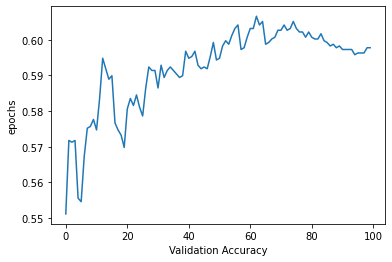

In [14]:
from matplotlib import pyplot as plt
plt.plot(val_accs)
plt.xlabel('Validation Accuracy')
plt.ylabel('epochs')
plt.show()